In [ ]:
from pandas import read_csv
from matplotlib import pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns
import scipy.stats as stats
from matplotlib import rcParams
from statsmodels.tsa.seasonal import seasonal_decompose
from scipy.ndimage.interpolation import shift
import statsmodels.tsa.api as smtsa
import statsmodels.api as sm
import statsmodels.stats as smst
import statsmodels.stats.api as sms
import statsmodels.tsa.stattools as smtst
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.stattools import adfuller
import random
import warnings
warnings.filterwarnings('ignore')
random.seed(123)
%matplotlib inline

# **Parte 3**

## **SERIES DE TIEMPO: ESTIMACIÓN DE UN MODELO SARIMAX CON RESERVAS INTERNACIONALES DEL B.C.R.A.**

#### Utilizaremos la serie Reservas Internacionales de Argentina comenzando la misma en Enero de 1960 a Agosto de 2021, con datos mensuales con saldos a fin de mes. 
#### Los datos fueron extraidos del Banco Central de la Republica Argentina, en millones de dólares a precios corrientes. Sus componentes incluyen Oro, divisas, colocaciones a plazo y otros.

In [ ]:
# Subimos el dataset cualquiera sea su ubicacion con el siguiente script.
from google.colab import files
files.upload()

Saving Reservas_panhis.xlsx to Reservas_panhis.xlsx


{'Reservas_panhis.xlsx': b'PK\x03\x04\x14\x00\x06\x00\x08\x00\x00\x00!\x00|l\x98\x16l\x01\x00\x00\xa0\x05\x00\x00\x13\x00\x08\x02[Content_Types].xml \xa2\x04\x02(\xa0\x00\x02\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x

In [ ]:
# Importamos nuestra serie y colocamos como ínidice la columna fecha.

series = pd.read_excel('Reservas_panhis.xlsx',index_col = 0)
# Buscamos un IPC volviendo los precios corrientes a precios constantes. Mes base enero de 1960 = 100.
series = series*0.0034
series.head()

,Reservas
Fecha,
1960-01-31,1.48104
1960-02-29,1.64050
1960-03-31,1.79758
1960-04-30,1.87102
1960-05-31,1.99376


In [ ]:
# Pedimos información sobre los datos.
series.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 740 entries, 1960-01-31 to 2021-08-31
Data columns (total 1 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Reservas  740 non-null    float64
dtypes: float64(1)
memory usage: 11.6 KB


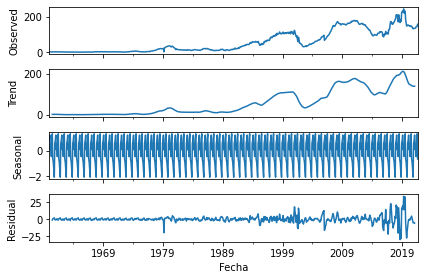

In [ ]:
# Aditivo
result = seasonal_decompose(series, model='aditive')
result.plot()
plt.show()

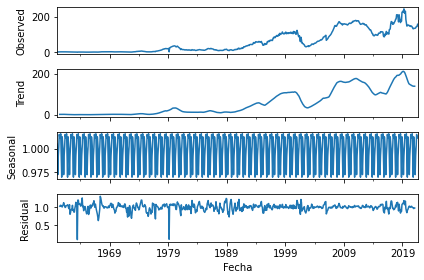

In [ ]:
# Multiplicativo
result = seasonal_decompose(series, model='multiplicative')
result.plot()
plt.show()

Observamos un dataset de 740 datos, sin datos faltantes, donde la variable reservas el del tipo flotante.

### **Por medio del método de Box & Jenkins se busca encontrar el modelo SARIMAX del cual proviene una serie de tiempo. Sus etapas son:**

#### **1) Transformación**
#### **2) Identificación**
#### **3) Estimación**
#### **4) Diagnóstico**
#### **5) Predicción**

### **1) Transformación**

##### En esta primer instancia analizaremos si nuestra serie cumple con los supuestos de no estacionalidad y de estacionariedad, el primero elimina los comportamientos tendenciales dentro de cada año, mientras que el segundo lo elimina de la serie completa. Si estos no se cumplen realizaremos las modificaciones que correspondan con el objetivo de poder realizar nuestra estimación.

Graficando la serie.

In [ ]:
import plotly.express as px

# Cantidad de preinscripciones por mes entre Agosto 2019 y Junio 2021
rcParams['figure.figsize'] = 20,10
px.line(series, y= series.Reservas,
        title = 'Gráfico n° #: Reservas Internacionales de Argentina, periodo 1960 - 2021')
# fig.text(.9,-.02, "Fuente: Elaboración propia en base a datos B.C.R.A.", 
#              fontsize = 13, fontweight = "bold", ha = "right")

In [ ]:
def my_ts_plot_2(serie, titulo, displayLags=40):
    fig = plt.figure(20)
    fig.set_figheight(8)
    fig.set_figwidth(8)

    fig.suptitle(titulo, fontsize = 14, fontweight = "bold")
    plt.subplots_adjust(top = 0.95)
    ax0 = plt.subplot2grid(shape=(2, 2), loc=(0, 0), colspan=2)
    ax1 = plt.subplot2grid(shape=(2, 2), loc=(1, 0), colspan=1)
    ax2 = plt.subplot2grid(shape=(2, 2), loc=(1, 1), rowspan=1)

    ax0.plot(serie)
    sm.graphics.tsa.plot_acf(serie, lags=displayLags, ax=ax1)
    sm.graphics.tsa.plot_pacf(serie, lags=displayLags, ax=ax2)
    fig.text(.9,-.02, "Fuente: Elaboración propia en base a datos B.C.R.A.", 
             fontsize = 13, fontweight = "bold", ha = "right")

    plt.show()

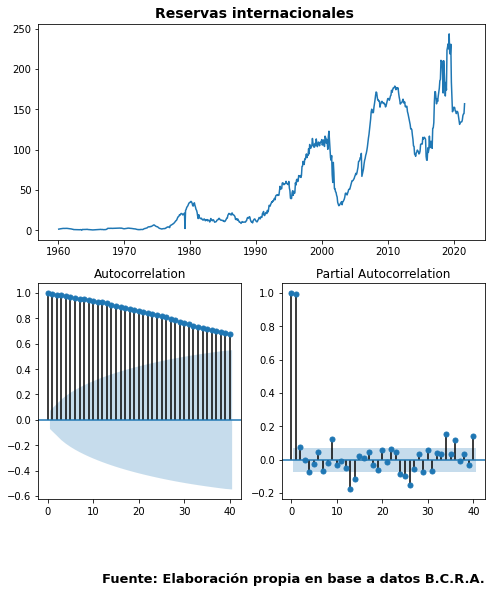

In [ ]:
my_ts_plot_2(series, 'Reservas internacionales')

En el primer gráfico observamos que la serie posee una tendencia positiva con algunos picos hacia abajo significativos en preriodos como 2002 a 2004 y 2011 a 2016, que aumenta con el correr de los meses, esto significa que no existe estacionariedad, además implica que la media no es constante mientras que la varianza no podemos decir nada sólo observando el primer gráfico. Debido a la gran cantidad en este gráfico no podemos observar presencia de estacionalidad, pero dado los datos mensuales no se descarta la posible presencia de esta última.

El gráfico de FAC (función de autocorrelación) los valores decrecen de manera muy lenta dada la presencia de no estacionariedad del modelo, además no observamos algún comportamiento que indique la presencia de estacionalidad, es decir no se logra observar un patrón que de indicios. Por este motivo no tomaremos primer diferencia estacional.

Observando la FACP (función de autocorrelación parcial) se registra a priori el primer retardo sea significativamente distinto de cero mientras que algunos como el lag 13 y el lag 26 entro otros pertenen al intervalo (-0.2, 0.2) no perteneciendo al grupo de los lags no significativos, el resto están dentro de las bandas. Este primer lag próximo a uno podría darnos indicios de presencia de un proceso autorregresivo de primer orden, ARIMA (1,0,0).

Dado lo anterior se debe proceder a eliminar la estacionariedad de nuestra serie. Para ello tomaremos primera diferencia, esperando que la misma se aplane.

In [ ]:
# Tomamos primer difencia a la serie.
series_dif = series.diff()
series_dif = series_dif.dropna()
series_dif.head()

,Reservas
Fecha,
1960-02-29,0.15946
1960-03-31,0.15708
1960-04-30,0.07344
1960-05-31,0.12274
1960-06-30,0.06732


Luego de tomar primer diferencia volvemos a realizar los gráficos de la serie y los FAC y FACP

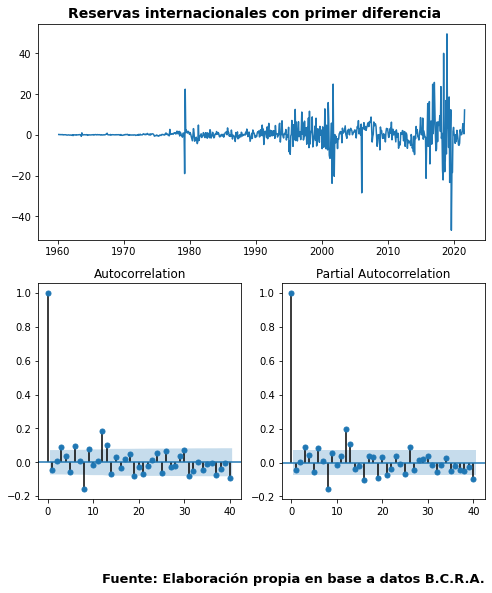

In [ ]:
# Pedimos la serie diferenciada a nuestra función
my_ts_plot_2(series_dif, 'Reservas internacionales con primer diferencia')

Tomando primera diferencia de la serie podemos observar la oscilación del primer gráfico está centrada en cero, o sea que logramos eliminar la tendencia positiva, esto puede significar que la media sea constante y cercana a cero, pero para los datos desde 1978 la variabilidad de las diferencias aumentan dando una premisa de que la varianza varia para distintas agrupaciones de datos, es decir no es constante para toda la serie. En este caso tenemos estacionariedad de primer orden.

Para eliminar la no estacionariedad en varianza usaremos la transformación de Box-Cox, es decir tomar logaritmos natural a la serie antes de diferenciarla.

In [ ]:
# Tomamos logaritmo natural a la serie original
series_log = series
series_log = np.log10(series_log)
series_log.head()

,Reservas
Fecha,
1960-01-31,0.170567
1960-02-29,0.214976
1960-03-31,0.254688
1960-04-30,0.272078
1960-05-31,0.299673


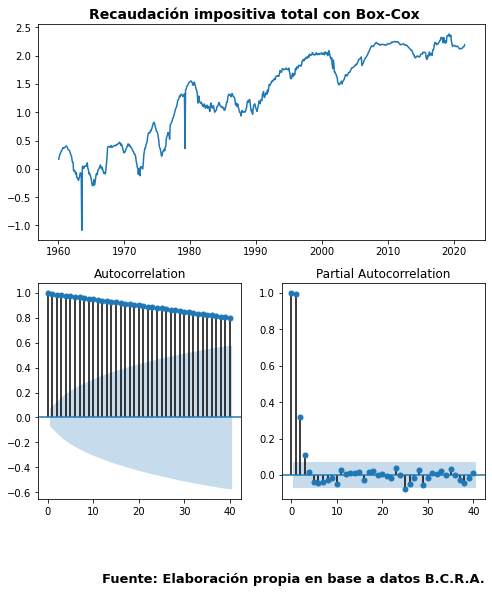

In [ ]:
my_ts_plot_2(series_log, 'Recaudación impositiva total con Box-Cox')

Luego de tomar logaritmo en base 10 a la serie vemos que la variabilidad de los datos es mucho menor, aunque hay evidencia de tendencia positiva aún. El gráfico FAC decrece de forma muy lenta y el FACP a simple vista pareciera que hay presencia de un modelo ARIMA(3,0,0) con tres retardos fuera de las bandas, sin embargo al no ser estacionaria la serie no esposible observar algún comportamiento.

Para intentar eliminar la no estacionariedad en media tomaremos primera diferencia y volveremos a observar los gráficos.

In [ ]:
# Tomamos primer diferencia a la serie en logaritmo natural.
series_log_dif = series_log.diff()
series_log_dif = series_log_dif.dropna(0)
series_log_dif.head()

,Reservas
Fecha,
1960-02-29,0.044409
1960-03-31,0.039712
1960-04-30,0.017390
1960-05-31,0.027594
1960-06-30,0.014422


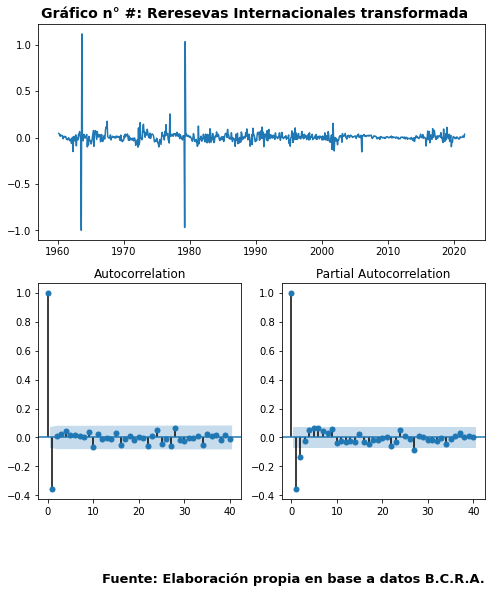

In [ ]:
my_ts_plot_2(series_log_dif, 'Gráfico n° #: Reresevas Internacionales transformada')

Tomando primer diferencia de la serie en el primer gráfico la variabilidad oscila en un rango cercano de -1 a 1, donde en sólo dos oportunidades llega a estos valores el resto se puede ver muy próximos a cero durante todo el recorrido de los datos. Esto es una premisa de presencia de estacionariedad en varianza constante y, en media constante y cercana a cero. 

En el gráfico FAC no observamos presencia de algún tipo de patrón, esto quiere decir que no hat estacionalidad en los datos, 

Esto permite que sea una potencial serie a aplicarle un modelo ARIMA. Entonces al haber tomado primera diferencia (d=1) observamos la presencia de un proceso integrado de orden uno (ARIMA(0,1,0)).
Con el objetivo de justificar el resultado obtenido, realizaremos el test de raíz unitaria de Dickey- Fuller aumentada. La dócima de hipótesis consta de:

* H0 : existe raíz unitaria, la serie de tiempo es no estacionaria
* H1 : la raíz no es unitaria, la serie de tiempo es estacionaria


In [ ]:
# # Para hacer la prueba de raíz unitaria de Dickey- Fuller aumentada:
# import statsmodels.tsa.stattools as smtst
# from statsmodels.tsa.stattools import adfuller

# resultad = smtst.adfuller(series_dif)
# print('ADF Statistic: %f' % resultad[0])
# print('p-value: %f' % resultad[1])
# print('Critical Values:')
# for key, value in resultad[4].items():
# 	print('\t%s: %.3f' % (key, value))

Con un p-value menor a un alpha de 0.05 podemos rechazar la H0 de existencia de raíz unitaria. Hay evidencia de que la serie transformada es estacionaria con un $\alpha$ = 0.05.

## 2) Identificación

Para poder conocer que tipo de proceso SARIMAX tenemos comenzamos a realizar distintos modelos.
En primer instancia replicamos el modelo que obtuvimos realizando la transformación de Box-Cox y primer diferencia de forma estacionaria, es decir un modelo $SARIMAX(0,1,0),(0,0,0)_12$.

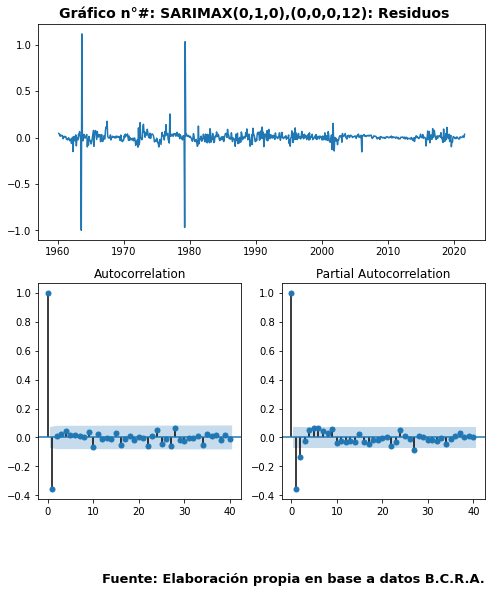

In [ ]:
# Estimación de residuos y correlogramas.
model = sm.tsa.statespace.SARIMAX(series_log_dif, trend='n', order=(0,0,0),seasonal_order=(0,0,0,12))
result = model.fit(disp=False)
residuos = result.resid
my_ts_plot_2(residuos, 'Gráfico n°#: SARIMAX(0,1,0),(0,0,0,12): Residuos')

Vemos el nuestro primer gráfico de los residuos de la serie y además de esos dos valores cercanos a 1 en valor absoluto, el resto se comportan proóximos a cero.

En el primer correlograma observamos un primer lag distinto de cero del cual podemos decir que podría ser un modelo de medias móviles de orden 1, algo similar ocurre con el corelograma FACP en el cual tenemos dos lags significativamente distintos de cero, esto da un preliminar de un modelo autorregresivo de orden dos. 

Es decir que buscaremos un modelo $SARIMAX(2,1,1),(0,0,0)_12$

Realizamos un $SARIMAX(1,1,0),(0,0,0)_12$

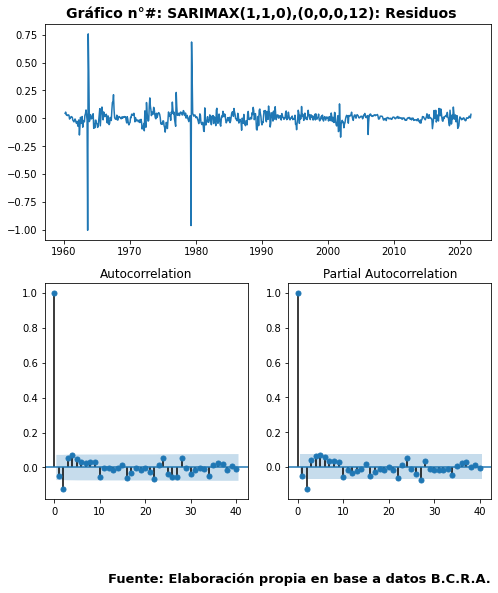

In [ ]:
# Pedimos otro modelo con un proceso autorregresivo de orden 1.
model = sm.tsa.statespace.SARIMAX(series_log_dif, trend='n', order=(1,0,0),seasonal_order=(0,0,0,12))
result = model.fit(disp=False)
residuos = result.resid
my_ts_plot_2(residuos, 'Gráfico n°#: SARIMAX(1,1,0),(0,0,0,12): Residuos')

Observamos en los correlogramas los segundos lags sin distintos de cero, esto nos dará un modelo autorregresivo de orden 2 y un modeso de medias móviles de orden 2 también, es decir un SARIMAX(2,1,2),(0,0,0)_12.

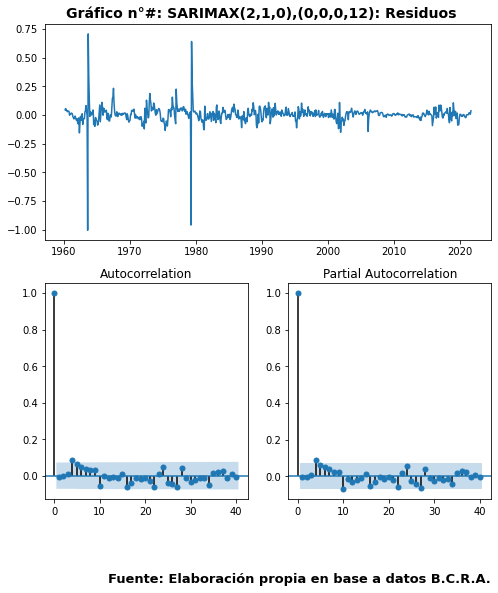

In [ ]:
# Estimamos un modelo con proceso autorregresivo de segundo orden.
model = sm.tsa.statespace.SARIMAX(series_log_dif, trend='n', order=(2,0,0),seasonal_order=(0,0,0,12))
result = model.fit(disp=False)
residuos = result.resid
my_ts_plot_2(residuos, 'Gráfico n°#: SARIMAX(2,1,0),(0,0,0,12): Residuos')

En este momento los retardos de ambos correlogramas vemos que casi todos los retardos pertenecen a las bandas pero no todos como ser el lag 4 o el 9, por lo qur ahora procederemos a calcular un proceso de media móviles de primer orden. Es decis un SARIMAX(2,1,1)(0,0,0)_12.

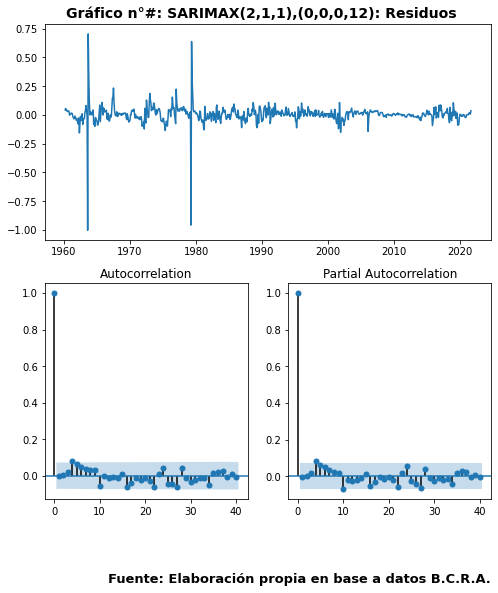

In [ ]:
model = sm.tsa.statespace.SARIMAX(series_log_dif, trend='n', order=(2,0,1),seasonal_order=(0,0,0,12))
result = model.fit(disp=False)
residuos = result.resid
my_ts_plot_2(residuos, 'Gráfico n°#: SARIMAX(2,1,1),(0,0,0,12): Residuos')

En los últimos correlogramas observamos todavía algunos retardos fuera de las bandas, entonces, tomando una media movil de orden dos, es decir un SARIMAX(2,1,2),(0,0,0)_12.

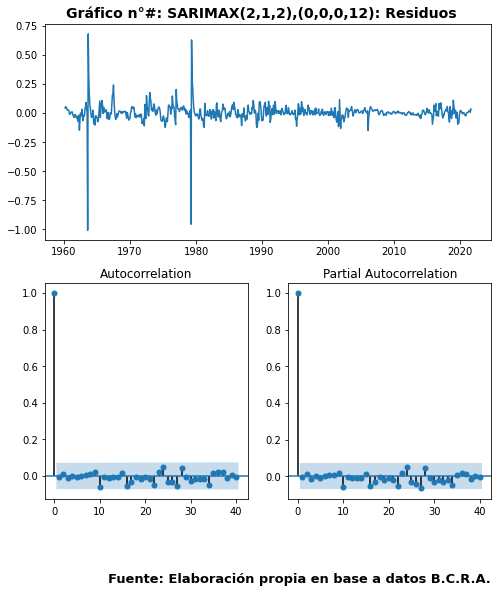

In [ ]:
model = sm.tsa.statespace.SARIMAX(series_log_dif, trend='n', order=(2,0,2),seasonal_order=(0,0,0,12))
result = model.fit(disp=False)
residuos = result.resid
my_ts_plot_2(residuos, 'Gráfico n°#: SARIMAX(2,1,2),(0,0,0,12): Residuos')

En este momento los retardos de ambos correlogramas son significativamente distintos de  cero, por lo que a priori podríamos estar frente a un modelo que nos sirva.

Para observar si este proceso nos sservirá para pronosticar, primero pedimos ver los coeficientes y sus pruebas de significancia, junto otros test que deben cumplirse estos supuestos.

In [ ]:
# Pedimos la salida del modelo SARIMAX(2,1,2),(0,0,0)_12.
print(result.summary())

                           Statespace Model Results                           
Dep. Variable:               Reservas   No. Observations:                  739
Model:               SARIMAX(2, 0, 2)   Log Likelihood                 836.276
Date:                Wed, 06 Oct 2021   AIC                          -1662.552
Time:                        17:48:03   BIC                          -1639.525
Sample:                    02-29-1960   HQIC                         -1653.673
                         - 08-31-2021                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.8643      0.124      6.966      0.000       0.621       1.107
ar.L2         -0.1292      0.041     -3.132      0.002      -0.210      -0.048
ma.L1         -1.2870      0.124    -10.346      0.0

En esta salida podemos observar varias cosas. La primera son los índices de AIC, BIC, HQIC, podemos decir que sus valores son bajos. 

Luego analizando la significancia de los coeficientes, con todos p-values menores al 0.05, entonces para cada coeficiente se rechara la hipótesis nula de que este sea igual a cero. Esto también lo confirmamos con los intervalos de confianza los cuales en ninguno está inluido el cero.

Para corroborar que hemos escogido el modelo más óptimo pediremos las salidas del proceso SARIMAX(2,1,1),(0,0,0,12) y compararemos quien tenga los menores índices de AIC, BIC, HQIC será mejor que el otro.

In [ ]:
# Estimación y cáculo de los indices de AIC, BIC, HQIC para un modelo SARIMAX(2,1,1),(0,0,0,12).
model = sm.tsa.statespace.SARIMAX(series_log_dif, trend='n', order=(2,0,1),seasonal_order=(0,0,0,12))
result = model.fit(disp=False)
residuos = result.resid
# my_ts_plot_2(residuos, 'Gráfico n°#: SARIMAX(2,1,1),(0,0,0,12): Residuos')
result.aic, result.bic, result.hqic

(-1651.7841507846517, -1633.362959100859, -1644.6811744460601)

## 3)Diagnóstico
#### En la misma salida tenemos los siguientes test:
* #### Test de Ljung-Box que prueba la no autocorrelación entre los residuos,
* #### Jarque Bera que analiza la normalidad de los residuos y
* #### Test ARCH LM que pretende probar existencia de homoscedasticidad, (o ausencia de heteroscedastidad) en los residuos.

#### Autocorrelación
 Test de __Ljung-Box__
* H0: Los datos se distribuyen de forma independiente (es decir, las correlaciones en la población de la que se toma la muestra son 0, de modo que cualquier correlación observada en los datos es el resultado de la aleatoriedad del proceso de muestreo).
* H1: Los datos no se distribuyen de forma independiente.


In [ ]:
# Calculamos el valor estadístico, el p_value y armamos una serie para mejor visualización.
resulTestLB = sms.acorr_ljungbox(residuos, lags = 3)     
Nombres = ["Estadístico LB", "p-value del estadístico LB"]
pd.Series(resulTestLB, index = Nombres)

Estadístico LB                [0.010373707514037146, 0.014296282139849582, 0...
p-value del estadístico LB    [0.9188746271013627, 0.9928773461256057, 0.969...
dtype: object

In [ ]:
# Con pandas
def my_lag_plot(serie, titulo):
    s = pd.Series(serie)
    y_t = s
    y_t_1 =s.shift(1)
    y_t_2 =s.shift(2)
    y_t_3 =s.shift(3)
    y_t_4 =s.shift(4)
    y_t_5 =s.shift(5)
    
    fig, (ax1, ax2, ax3, ax4, ax5) = plt.subplots(1, 5, figsize=(20,3))
    fig.suptitle(titulo, fontsize = 14, fontweight = "bold")
    ax1.scatter(y_t, y_t_1)
    ax2.scatter(y_t, y_t_2)
    ax3.scatter(y_t, y_t_3)
    ax4.scatter(y_t, y_t_4)
    ax5.scatter(y_t, y_t_5)
    plt.show()

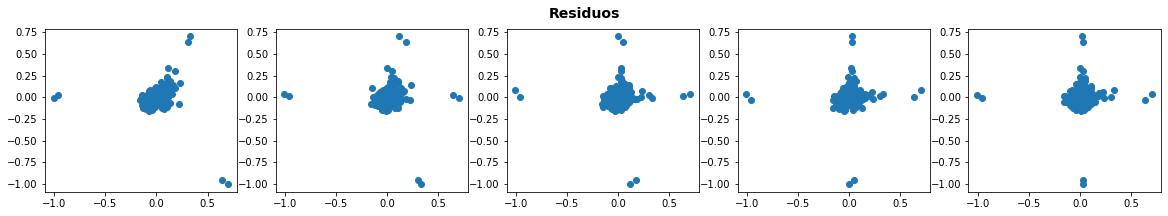

In [ ]:
my_lag_plot(residuos, 'Residuos' )

Observamos que para nuestro tres primeros lags un p-value mayor a un $\alpha = 0.05$, por lo que no rechazamos la H0 de independencia o ausencia de autocorrelación de los residuos. Cumpliendose el primer supuesto del modelo.

#### Heteroscedasticidad
Realizamos el test de __ARCH LM__
* H0 : presencia de homoscedasticidad en las variabilidad de los residuos, es decir la variabilidad de los datos permanece constante.
* H1 : presencia de heteroscedasticidad en la variabilidad de los residuos, es decis la variabilidad de los residuos varia en el tiempo.

In [ ]:
# Realizamos la puebra ARCH LM, guardamos los resultados y creamos una serie para su mejor visualización.
resultARCHLM = smst.diagnostic.het_arch(residuos, maxlag=None)
Nombres = ['LM', 'p-value', 'F', 'p-value']
pd.Series(resultARCHLM, index = Nombres)

LM         1.326574e+02
p-value    1.234668e-18
F          7.895969e+00
p-value    8.189796e-21
dtype: float64

Observamos nuestros valores p-value para ambos tipos de pruebas son menores a un $\alpha = 0.05$ por lo que se rechaza la H0 de homoscedasticidad, es decir hay evidencia significativa de variabilidad en la varianza de los residuos a un 95% de significancia.

#### Normalidad
Luego, para ver la normalidad de los residuos, mediante la prueba de __Jarque-Bera__:
* H0 : residuos se distribuyen normal
* H1 : residuos no se distribuyen normal

In [ ]:
# Hacemos la prueba de Jarque_Bera
j_b = stats.jarque_bera(residuos) 
Nombres = ["Estadístico Jarque Bera", "p-value"]
pd.Series(j_b, index = Nombres)

Estadístico Jarque Bera    197042.320532
p-value                         0.000000
dtype: float64

Con un p-value cercano a cero, menos a un $\alpha = 0.05$ se rechaza la H0 de normalidad, esto quiere decir que no hay presencia de una distribución aleatoria en los residuos del modelo.

Observando el gráfico, podemos confirmar esto.

In [ ]:
# Usando la librería plotly para los residuos del modelo.
rcParams['figure.figsize'] = 20,10
px.scatter(x=residuos.index, y= residuos,
        title = 'Gráfico n° #: Residuos del modelo SARIMAX(2,1,2)(0,0,0)_12')

Una vez más confimamos la ausencia de normalidad en los residuos. 

Dada la presencia de heteroscedasticidad y no normalidad de los residuos, además del comportamiento que estos presentan para los meses de Julio, Agosto y Septiembre de 1963, y para Marzo y Abril de 1979, nos da la sospecha de que en esos periodos de tiempo ocurrió algún hecho que no habiamos tenido en cuenta al analizar la serie en un principio. Existe la posibilidad de quiebres estructurales para uno o ambos periodos, por lo que pasamos a analizar estas situaciones.

## 5) Predicción

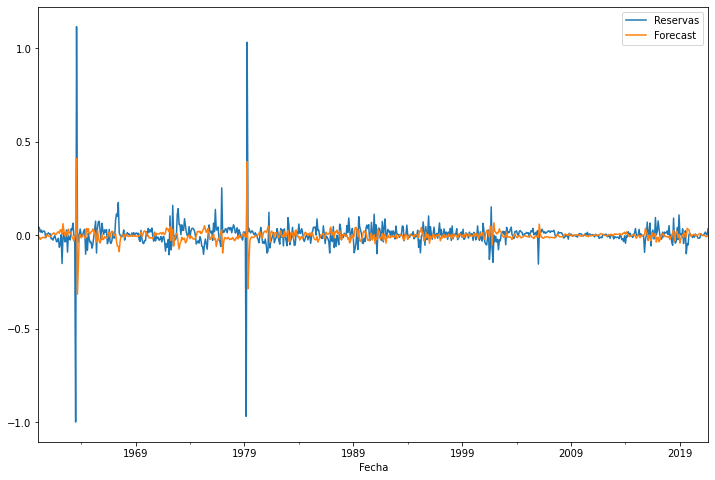

In [ ]:
data= pd.DataFrame()
data['Reservas'] = series_log_dif['Reservas']
data['Forecast'] = result.predict(start = 0, end = 739, dynamic= False)  
data[['Reservas', 'Forecast']].plot(figsize=(12, 8))
plt.show()

# De acá en adelante son pruebas mías

In [ ]:
ResultadosTestCUSUM = sms.breaks_cusumolsresid(residuos)
print(ResultadosTestCUSUM)

(1.6103127264921004, 0.011186281152080011, [(1, 1.63), (5, 1.36), (10, 1.22)])


In [ ]:
Nombres = ["Estadístico", "p-value del estadístico", "Valores críticos"]
pd.Series(ResultadosTestCUSUM, index = Nombres)

Estadístico                                           1.61031
p-value del estadístico                             0.0111863
Valores críticos           [(1, 1.63), (5, 1.36), (10, 1.22)]
dtype: object

In [ ]:
# Diagnostic
#result.plot_diagnostics(figsize=(16, 8))
#plt.show()

**Notas**

Produce una cuadrícula de parcelas de 2x2 con las siguientes parcelas (ordenadas en el sentido de las agujas del reloj desde la parte superior izquierda):

* Residuos estandarizados a lo largo del tiempo

* Histograma más densidad estimada de residuos estandarizados, junto con una densidad Normal (0,1) graficada como referencia.

* Gráfico QQ normal, con línea de referencia normal.

* Correlograma

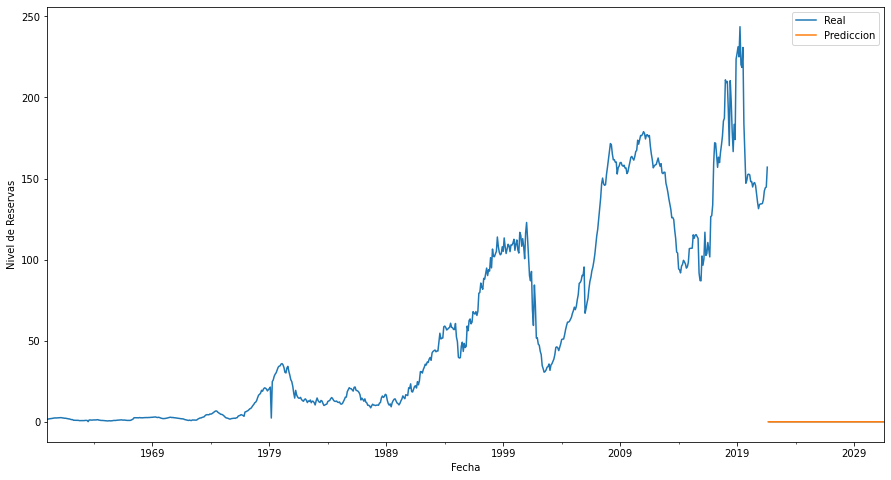

In [86]:
# Prediccion del Modelo Sarimax
#reservas = series['Reservas']
#pred_f = result.get_forecast(120)
#pred_ci = pred_f.conf_int()
#ax = reservas.plot(label='Real', figsize=(15, 8))
#pred_f.predicted_mean.plot(ax=ax, label='Prediccion')
#ax.fill_between(pred_ci.index,
#                pred_ci.iloc[:, 0],
#                pred_ci.iloc[:, 1], color='k', alpha=0.2)
#ax.set_xlabel('Fecha')
#ax.set_ylabel('Nivel de Reservas')
#plt.legend()
#plt.show()

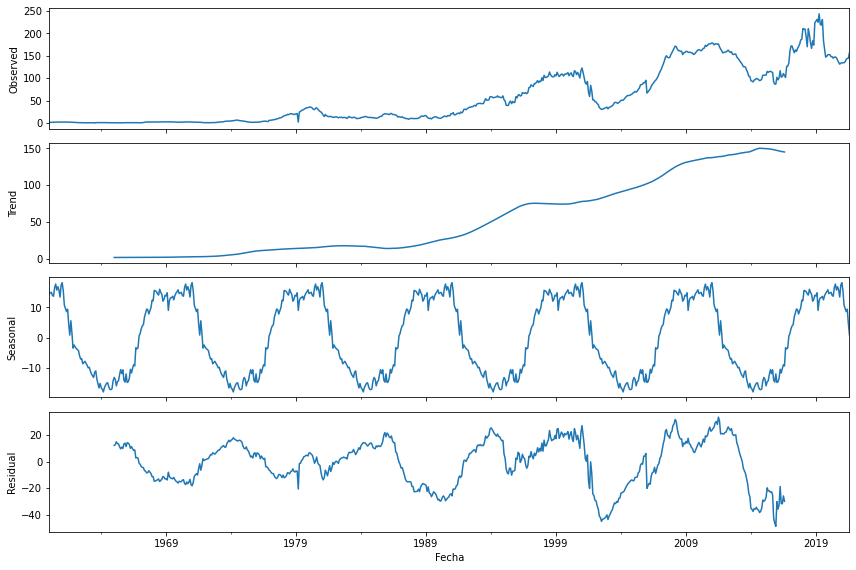

In [92]:
# Descomposicion temporal
#decomposition = seasonal_decompose(reservas, freq=120, model='additive')
#plt.rcParams['figure.figsize'] = 12, 8
#decomposition.plot()
#plt.show();

In [ ]:
#ResultadosRR = sms.recursive_olsresiduals(result, alpha=0.95)   # sirve para crear las series de residuos recursivos (rresid),
                                                                    # parámetros recursivos (rparams), valores predichos recursivos (rypred),
                                                                    # residuos recursivos estandarizados (rresid_standardized),
                                                                    # residuos recursivos escalados (rresid_scaled)
                                                                    # suma acumulada de residuos recursivos para el test CUSUM (rcusum) y
                                                                    # los límites de confianza para el test CUSUM (rcusumci) con el alpha especificado

In [ ]:
#import statsmodels.stats.diadnostic as smsd
#r= smst.diagnostic.recursive_olsresiduals(result,alpha=0.95)

In [ ]:
# Nombres = ["rresid", "rparams", "rypred", "rresid_standardized", "rresid_scaled", "rcusum", "rcusumci"]
# frame = pd.Series(ResultadosRR, index = Nombres)

In [ ]:
# fig, ax = plt.subplots(figsize = (10,5))
# fig.suptitle("Test CUSUM", fontsize = 18, fontweight = "bold")
# ax.plot(frame.rcusum, color = "darkblue")
# ax.plot(frame.rcusumci[0], color = "red", linestyle = '--')
# ax.plot(frame.rcusumci[1], color = "red", linestyle = '--')
# ax.set_xlabel("Observaciones", fontsize = 15)
# ax.set_ylabel("CUSUM", fontsize = 15)
# ax.tick_params(labelsize = 14)
# fig.text(.9,-.02, "Elaboración propia en base a Triana (2019)", fontsize = 13, fontweight = "bold", ha = "right")
# plt.show()

In [ ]:
#series = series.reset_index()
series.head()

,Reservas
Fecha,
1960-01-31,1.48104
1960-02-29,1.64050
1960-03-31,1.79758
1960-04-30,1.87102
1960-05-31,1.99376


In [ ]:
mask = (series[''] > start_date) & (df['col'] <= end_date)

KeyError: ignored

In [ ]:
series['Dummy'] = series[(series['Dummy'] > '1960') & (df['date'] < '2013-02-01')]

In [ ]:
for  series.loc['1960-01-31': '1963-06-30']:
    series['Dummy'] == FALSE
elif series.loc['1963-07-31':'2021-08-31']:
    series['Dummy'] == TRUE

In [ ]:
#cero = series.loc['1960-01-31': '1963-06-30']
cero['Dummy'] = 0
#len(series.loc['1963-07-31': '2021-08-31'])

#series.loc[series['Reservas'].between('1960-01-31', '1963-07-31')]

In [97]:
series.dtypes

Reservas    float64
dtype: object

In [98]:
series['Reservas']

Fecha
1960-01-31      1.48104
1960-02-29      1.64050
1960-03-31      1.79758
1960-04-30      1.87102
1960-05-31      1.99376
                ...    
2021-04-30    136.89352
2021-05-31    142.36412
2021-06-30    144.28546
2021-07-31    144.77778
2021-08-31    157.01302
Name: Reservas, Length: 740, dtype: float64